# Tutorial 3: Deep learning classifiers for bifurcation prediction

This tutorial assumes that you are familiar with the tools demonstrated in Tutorial 1.

By the end of this tutorial you should know how to:
- Import a TensorFlow classifier and obtain its predictions on a section of time series data
- Compute predictions made from an ensemble of classifiers


We will be using the classifiers trained in the study by [Bury et al. (PNAS, 2021)](https://royalsocietypublishing.org/doi/full/10.1098/rsif.2020.0482). See details therein to train your own classifier.

Notebook run time : 2 min 18 s on Macbook Air (M1, 2020)

## Motivation

Early warning signals based on time series statistics such as variance and lag-1 autocorrelation can signal the approach of a bifurcation, however they do not provide information on the type of bifurcation that is approaching. Knowledge of the bifurcation type is important as different bifurcations can give rise to very different dynamics following the bifurcation. A recent study [(Bury et al. (PNAS, 2021))](https://www.pnas.org/doi/10.1073/pnas.2106140118) showed that deep learning classifiers can be trained on a large number of bifurcation trajectories to predict bifurcations and their type in time series data. The approach had getter statistical performance (as measured by ROC curves) at predicting bifurcations on model and empirical data sources. Here, we will demonstrate how to apply these deep learning classifiers to time series data using *ewstools*. Feel free to modify this notebook to use your own time series data.

## Import libraries

In [1]:
# Start timer to record execution time of notebook
import time
start_time = time.time()

In [2]:
import numpy as np
np.random.seed(0) # Set seed for reproducibility

import pandas as pd
import matplotlib.pyplot as plt
import os

from IPython.display import Image

import ewstools
from ewstools.models import simulate_may, simulate_rosen_mac

In [3]:
# Tensorflow imports
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # comment out to see TensorFlow warnings 
from tensorflow.keras.models import load_model

## Simulate model data

We will use May's harvesting model to simulate a fold bifurcation, and the Rosenzweig-MacArthur (RM) consumer-resource model to simulate a Hopf and a transcritical bifurcation. The functions in *ewstools* to simulate these models are [`simulate_may()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.models.simulate_may) and [`simulate_rosen_mac()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.models.simulate_rosen_mac), respectively. Let's simulate trajectories and plot them in matplotlib.

In [4]:
series_may = simulate_may(tmax=500, dt=0.01, h=[0.15,0.28]).iloc[::100]
series_rm_hopf = simulate_rosen_mac(tmax=500, dt=0.01, a=[12,16]).iloc[::100]
series_rm_tc = simulate_rosen_mac(tmax=500, dt=0.01, a=[2,6]).iloc[::100]

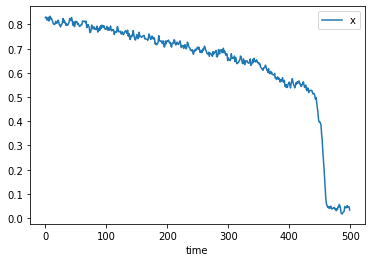

In [5]:
series_may.plot();

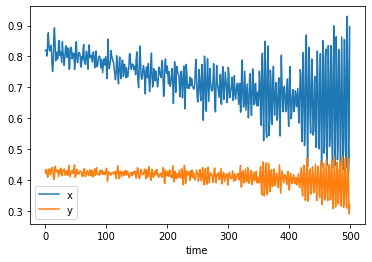

In [6]:
series_rm_hopf.plot();

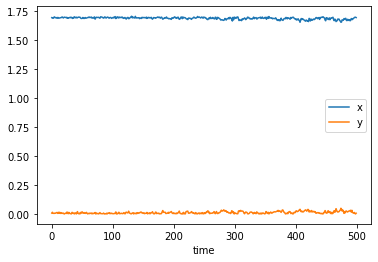

In [7]:
series_rm_tc.plot();

## Set up TimeSeries object and detrend

As per usual, we now define a [`TimeSeries`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries) object for each time series we wish to analyse. Recall that this only takes in univariate time series (future versions of *ewstools* may accomodate multivariate time series), so the resource (x) and consumer (y) variables in the RM model would need to assigned to separate objects. For this tutorial we will focus on the resource variable.

The [`TimeSeries`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries) object can also take in a transition time, beyond which EWS are not computed. Here, we will just eyeball the transition times. A more rigorous approach could be to use change-point algorithms, or use the time that the bifurcation is crossed in the model.

In [8]:
ts_may = ewstools.TimeSeries(series_may['x'], transition=420)
ts_rm_hopf = ewstools.TimeSeries(series_rm_hopf['x'], transition=420)
ts_rm_tc = ewstools.TimeSeries(series_rm_tc['x'], transition=420)

Now let's detrend the data using the method [`detrend()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.detrend). Since the deep learning classifiers are trained on data that has been detrended with a Lowess filter of span 0.2, we will use the same approach here.

In [9]:
ts_may.detrend(method='Lowess', span=0.2)
ts_rm_hopf.detrend(method='Lowess', span=0.2)
ts_rm_tc.detrend(method='Lowess', span=0.2)

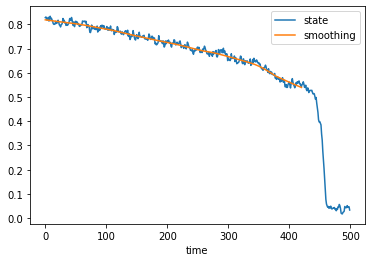

In [10]:
ts_may.state[['state','smoothing']].plot();

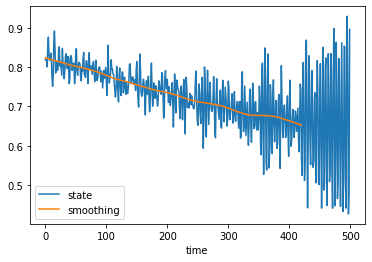

In [11]:
ts_rm_hopf.state[['state','smoothing']].plot();

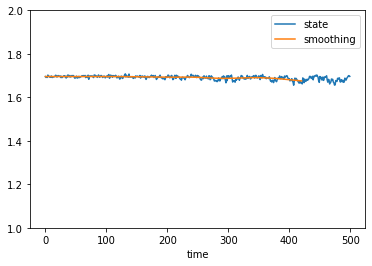

In [12]:
ts_rm_tc.state[['state','smoothing']].plot(ylim=[1,2]);

## Compute predictions of a DL classifier

The method [`apply_classifier()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.apply_classifier) applies a deep learning classifier (a TensorFlow [`Model`](https://www.tensorflow.org/api_docs/python/tf/keras/Model)) to a segment of the time series data, specified using `tmin` and `tmax`. The prediction (a vector of probabilites for each class) is then saved into the attribute `dl_preds`, which is a pandas DataFrame.

Let's see this in action. We will import one of the classifiers that was trained in [Bury et al. (PNAS, 2021)](https://www.pnas.org/doi/10.1073/pnas.2106140118). These are saved in the *ewstools* Github repository under [/saved_classifiers](https://github.com/ThomasMBury/ewstools/tree/main/saved_classifiers/bury_pnas_21) for convenience. These classifiers were trained to predict the following classes:

| Key | Trajectory |
| :- | :- |
| 0 | fold bifurcation |
| 1 | Hopf bifurcation | 
| 2 | transcritical bifurcation |
| 3 | null |

In [13]:
classifier_path = '../saved_classifiers/bury_pnas_21/len500/best_model_1_1_len500.pkl'
classifier = load_model(classifier_path)

Let's apply the classifier to the fold trajectory using data from time 0 to time 400.

In [14]:
ts_may.apply_classifier(classifier, tmin=0, tmax=400)

2022-07-16 10:13:02.121813: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 335ms/step


We can view the predictions inside the attribute `dl_preds`.

In [15]:
ts_may.dl_preds

,0,1,2,3,time,classifier
0,0.751295,0.030536,0.21511,0.003059,400,c1


The probabiltiy assigned to class 0 (fold bifurcation) is the largest, demonstrating that given most of the time series, the classifier correctly interprets it as a trajectory approaching a fold bifurcation.

We would really like to know the predictions vary as the classifier sees progressively more of the time series. That is where the method [`apply_classifier_inc()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.apply_classifier_inc) comes in. This applies the classifier to incrementally longer segments of the time series. Each segment starts at the earliest point in the time series, and ends at a point that is incremented by an amount `inc` defined by the user. The longest time series segment will be the one that goes as close to the bifurcation as possible. Using this function saves a list of predictions to `dl_preds`, that we can visualise to get a feel for how the classifier behaves as a function of time.

In [16]:
ts_may.clear_dl_preds() # Clear previous data in dl_preds
ts_may.apply_classifier_inc(classifier, inc=10, verbose=0) # Set verbose=1 to see progress

Now `dl_preds` should contain many predictions each made at a different time. (The time of prediction is of course the end time of the time series segment that the classifier is applied to).

In [17]:
ts_may.dl_preds.head()

,0,1,2,3,time,classifier
0,0.207065,0.339513,0.247485,0.205937,0.0,c1
1,0.228072,0.376060,0.219008,0.176861,10.0,c1
2,0.250696,0.294206,0.267425,0.187674,20.0,c1
3,0.225095,0.144681,0.282058,0.348166,30.0,c1
4,0.212830,0.046121,0.296307,0.444743,40.0,c1


We can visualise the predictions using the method [`make_plotly()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.make_plotly).

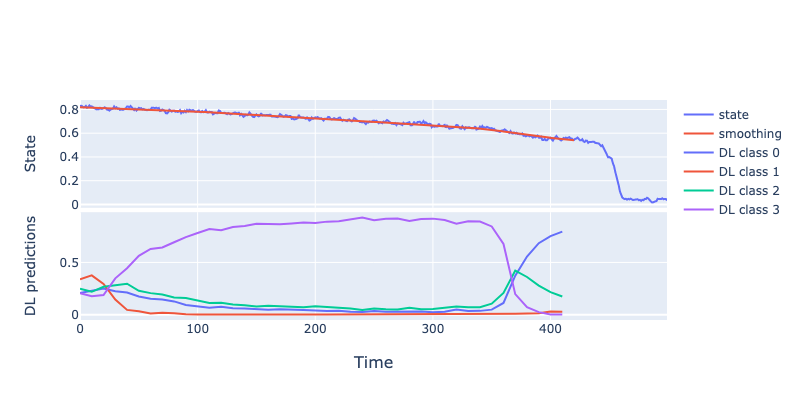

In [18]:
fig = ts_may.make_plotly()
Image(fig.to_image()) # use fig.show() to show interactive figure

We see that it was around t=370 that the classifier decided this was most likely a 'fold' trajectory. Let's perform the same analysis for the 'Hopf' and 'transcritical' trajectories in the RM model.

In [19]:
ts_rm_hopf.clear_dl_preds()
ts_rm_tc.clear_dl_preds()
ts_rm_hopf.apply_classifier_inc(classifier, inc=10, verbose=0)
ts_rm_tc.apply_classifier_inc(classifier, inc=10, verbose=0)

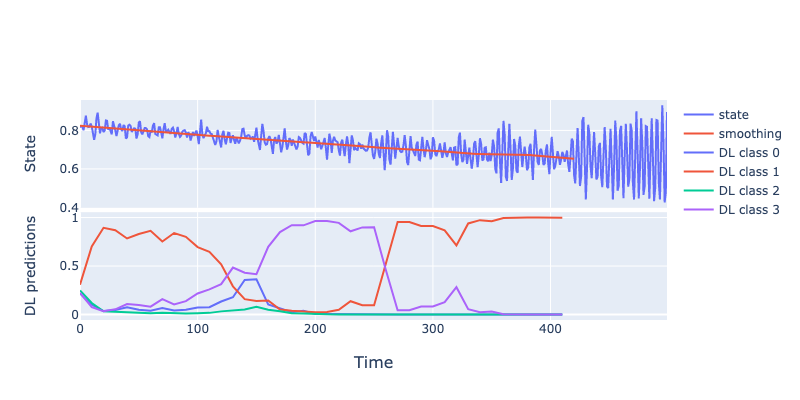

In [20]:
fig = ts_rm_hopf.make_plotly()
Image(fig.to_image()) # use fig.show() to show interactive figure

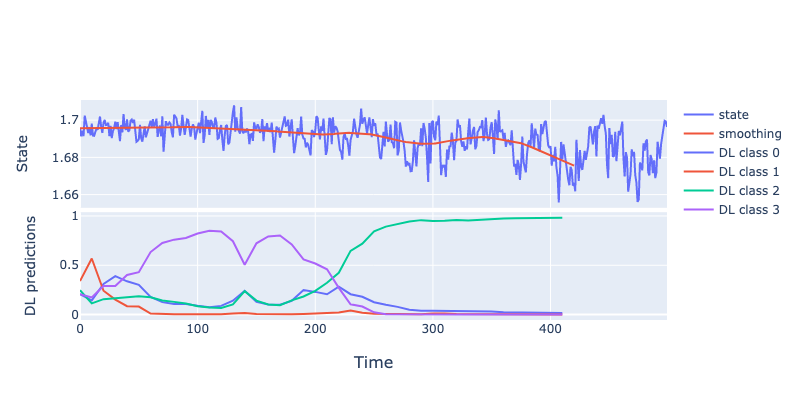

In [21]:
fig = ts_rm_tc.make_plotly()
Image(fig.to_image()) # use fig.show() to show interactive figure

We see that the classifier correctly identifies the type of these trajectories, and seems to do so earlier than for the fold trajectory.

## Ensemble modelling

The previous predictions were obtained from a single classifier. To improve overall performance, we can use ensemble modelling, which involves taking the average of predictions from multiple classifiers. Let's import 6 out of the 20 classifiers that were trained in the PNAS study (ideally all 20 should be used, but we'll save time for this tutorial). Let's apply the to the fold trajectory in May's model.

In [22]:
# Clear previous DL predictions
ts_may.clear_dl_preds()

In [23]:
# Get classifier names
root_path = '../saved_classifiers/bury_pnas_21/len500/'
classifier_names = [name[:-4] for name in os.listdir(root_path) if name[-4:]=='.pkl']

In [ ]:
# This cell takes ~ 1 minute to run on Macbook Air (M1, 2020)
for classifier_name in classifier_names[:6]:
    # Import classifier
    classifier = load_model(root_path + classifier_name + '.pkl')
    # Get DL predictions - note we can provide a classifier name for reference
    ts_may.apply_classifier_inc(classifier, inc=10, verbose=0, name=classifier_name)
    print('Predictions complete for classifier {}'.format(classifier_name))

Now *dl_preds* should contain predictions made from multiple classifiers:

In [ ]:
ts_may.dl_preds['classifier'].unique()

If we now visualise the predictions with [`make_plotly()`](https://ewstools.readthedocs.io/en/latest/ewstools.html#ewstools.core.TimeSeries.make_plotly), we should see multiple traces for each class, each one corresponding to one of the classifiers.


In [ ]:
ts_may.make_plotly()

There is the option to plot the ensemble average, which can be achieved by setting `ens_av` to true.

In [ ]:
ts_may.make_plotly(ens_avg=True)

That's it! Feel free to copy and play around with this notebook for your own data.

In [ ]:
# Stop timer
end_time = time.time()
print('Notebook took {:.1f}s to run'.format(end_time-start_time))